In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.integrate
import itertools as it
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from spectral import *
def diff(a, b):
    a = np.asarray(a)
    b = np.asarray(b)
    return 2*np.linalg.norm(a - b)/np.linalg.norm(a + b)

In [2]:
def c2xyz(p):
    x, r, phi = p
    return x, r*np.cos(phi), r*np.sin(phi)

def xyz2c(xyz):
    x, y, z = xyz
    return x, np.sqrt(y**2 + z**2), np.arctan2(z, y)

def transform_matrix(p):
    "Return transformation matrix or a stack of such matrices"
    x, r, phi = p
    Q = np.zeros(np.shape(phi) + (3, 3))
    Q[...,0,0] = 1
    Q[...,1,1] = Q[...,2,2] = np.cos(phi)
    Q[...,2,1] = -np.sin(phi)
    Q[...,1,2] = np.sin(phi)
    return Q

def tensor_c2xyz(A, p):
    Q = transform_matrix(p)
    return np.einsum('...ij,...ik,...jl->...kl', A, Q, Q)

def tensor_xyz2c(A, xyz):
    Q = transform_matrix(xyz2c(xyz))
    return np.einsum('...ij,...ki,...lj->...kl', A, Q, Q)

def vector_c2xyz(v, p):
    Q = transform_matrix(p)
    return np.einsum('...i,...ik->...k', v, Q)

def vector_xyz2c(v, xyz):
    Q = transform_matrix(xyz2c(xyz))
    return np.einsum('...i,...ki->...k', v, Q)

In [3]:
p = [1, 2], [2, 3], [3, 1]
xyz = c2xyz(p)
p2 = xyz2c(xyz)
diff(p, p2)

4.6915485647975684e-17

In [4]:
v = [3, 4, 5]
v2 = vector_xyz2c(vector_c2xyz(v, p), xyz)
diff(v, v2)

1.6616296724220896e-16

In [5]:
A = [[3, 4, 5], [6, 7, 8], [9, 10, 11]]
A2 = tensor_xyz2c(tensor_c2xyz(A, p), xyz)
diff(A, A2)

1.523973320317618e-16

In [6]:
L, R = 3, 2
mesh_x = Legendre(6, (0, L))
mesh_r = Legendre(22, (R, 0), 'Radau')
mesh_phi = Fourier(22, (-np.pi, np.pi))
mesh = mesh_x*mesh_r*mesh_phi

In [7]:
def random_field(*shape):
    mesh = Legendre(6, (0, L))*Legendre(6, (-R, R))*Legendre(6, (-R, R))
    return TensorField(mesh, np.random.randn(*shape, *mesh.shape))

def random_point():
    x = np.random.uniform(*mesh_x.endpoints)
    r = np.random.uniform(*mesh_r.endpoints)
    phi = np.random.uniform(*mesh_phi.endpoints)
    return x, r, phi

In [8]:
def plot(field, x, r_points=500, phi_points=500, figsize=4, xyz=True):
    polar_field = field(x)
    r = np.linspace(*polar_field.mesh.mesh1.endpoints, r_points)
    phi = np.linspace(*polar_field.mesh.mesh2.endpoints, phi_points)
    data = polar_field(r, phi)
    rank = data.ndim - 2
    if xyz:
        if rank == 2:
            data = tensor_c2xyz(data, (x,) + np.ix_(r, phi))
        elif rank == 1:
            data = vector_c2xyz(data, (x,) + np.ix_(r, phi))
        coord_names = 'xyz'
    else:
        coord_names = 'xrφ'
        
    names = list(''.join(t) for t in it.product(coord_names, repeat=rank))
    
    rows, cols = np.atleast_2d(data[0, 0]).shape
    data = data.reshape(data.shape[:2] + (-1,))

    plt.figure(figsize=(figsize*cols, figsize*rows))
    for i in range(cols*rows):
        ax = plt.subplot(rows, cols, 1 + i, projection="polar")
        m = ax.pcolormesh(phi, r, data[...,i], vmin=data.min(), vmax=data.max())
        plt.xticks([])
        plt.yticks([])
        plt.text(3/4*np.pi, 1.3*R, 'U' + names[i])
    plt.subplots_adjust(hspace=0.05, wspace=0.05)
    plt.colorbar(m, ax=plt.gcf().get_axes())    
    plt.show()  

## Gradient of a scalar field

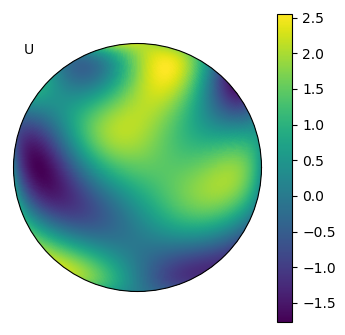

In [9]:
x, y, z = c2xyz(np.ix_(*mesh.grid()))
rf = random_field()                       
u = TensorField(mesh, np.vectorize(rf)(x, y, z))
plot(u, x=1)

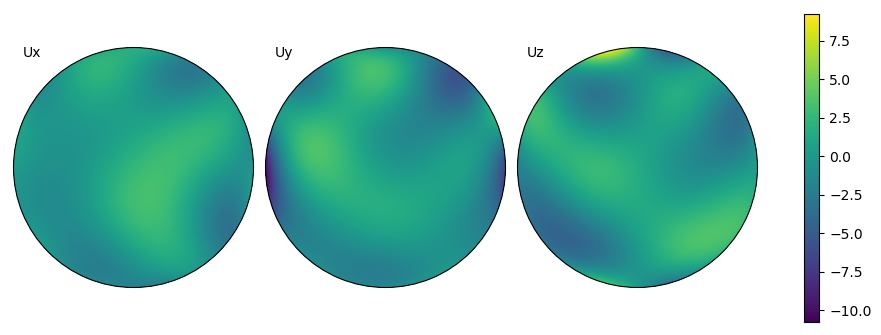

In [10]:
grad_u = u.grad(coord='cylindrical')
plot(grad_u, x=1)

In [11]:
p = random_point()
xyz = c2xyz(p)
v = grad_u(*p)
eps = 1e-6
v1_xyz = [(u(*xyz2c(xyz + delta)) - u(*xyz2c(xyz - delta)))/2/eps
          for delta in eps*np.eye(3)]
v1 = vector_xyz2c(v1_xyz, xyz)
diff(v, v1)

1.264073446439655e-10

## Gradient of a vector field

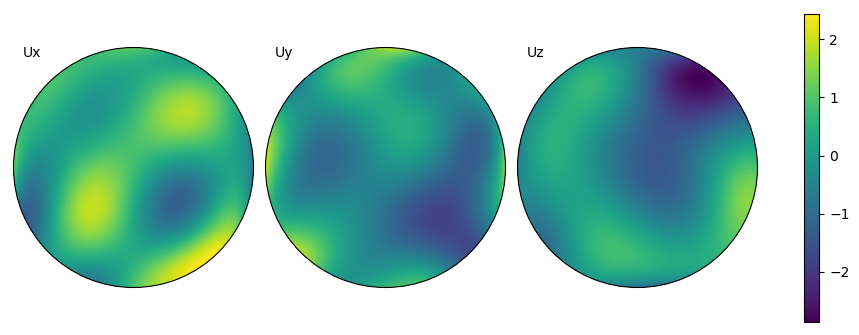

CPU times: user 12 s, sys: 299 ms, total: 12.3 s
Wall time: 8.91 s


In [12]:
%%time
rf = random_field(3)
b = np.broadcast(*c2xyz(np.ix_(*mesh.grid())))
data = np.array([vector_xyz2c(rf(*xyz), xyz) for xyz in b])
data = data.T.reshape(3, *mesh.shape)
u = TensorField(mesh, data)
plot(u, x=1)

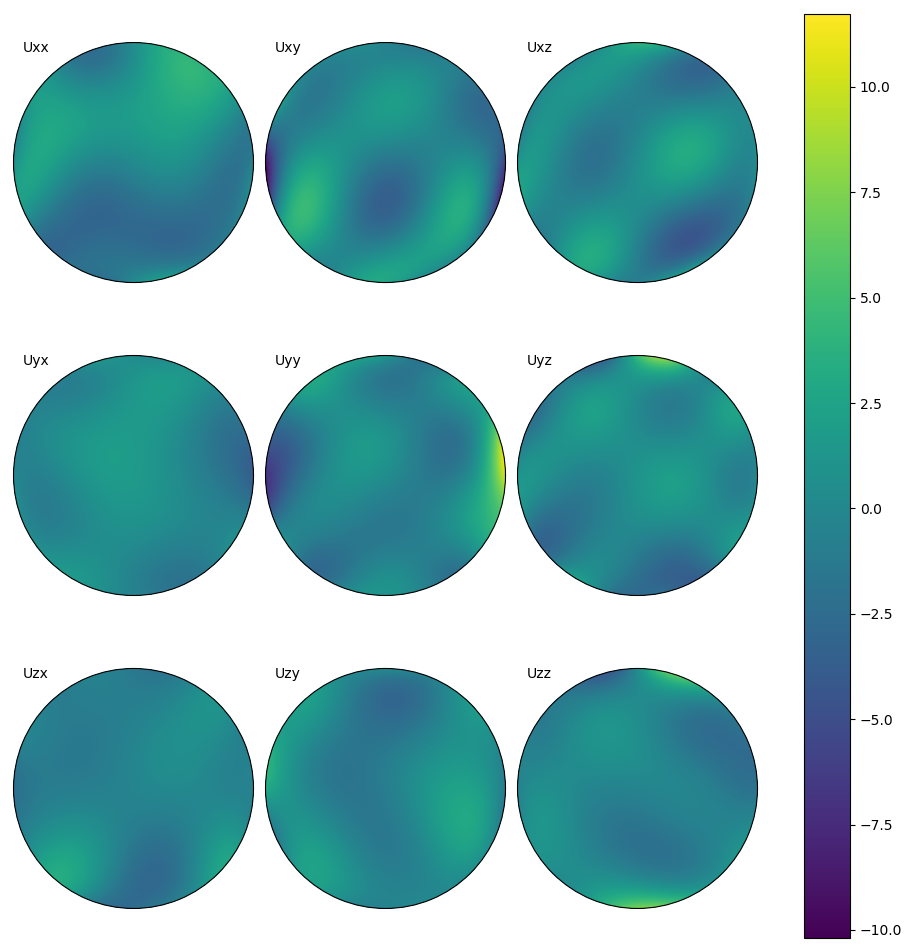

In [13]:
grad_u = u.grad(coord='cylindrical')
plot(grad_u, x=1)

In [14]:
p = random_point()
xyz = c2xyz(p)
A = grad_u(*p)

eps = 1e-5
d = [vector_c2xyz(u(*xyz2c(xyz + delta)), xyz2c(xyz + delta)) - 
     vector_c2xyz(u(*xyz2c(xyz - delta)), xyz2c(xyz - delta))
     for delta in eps*np.eye(3)]
A1_xyz = np.transpose(d)/2/eps
A1 = tensor_xyz2c(A1_xyz, xyz)
diff(A, A1)

2.0198135616253131e-10

## Divergence of a vector field

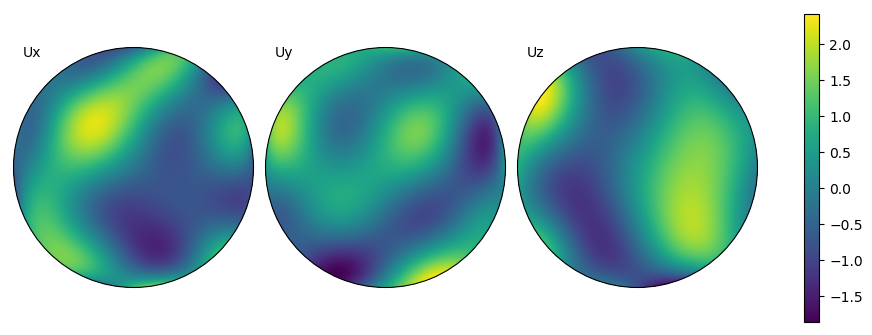

CPU times: user 11.9 s, sys: 273 ms, total: 12.2 s
Wall time: 9.13 s


In [15]:
%%time
rf = random_field(3)
b = np.broadcast(*c2xyz(np.ix_(*mesh.grid())))
data = np.array([vector_xyz2c(rf(*xyz), xyz) for xyz in b])
data = data.T.reshape(3, *mesh.shape)
u = TensorField(mesh, data)
plot(u, x=1)

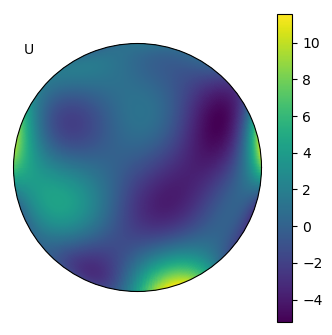

In [16]:
div_u = u.div(coord='cylindrical')
plot(div_u, x=1)

In [17]:
p = random_point()
xyz = c2xyz(p)
s = div_u(*p)

eps = 1e-5
d = [vector_c2xyz(u(*xyz2c(xyz + delta)), xyz2c(xyz + delta)) - 
     vector_c2xyz(u(*xyz2c(xyz - delta)), xyz2c(xyz - delta))
     for delta in eps*np.eye(3)]
s1 = np.trace(d)/2/eps
diff(s, s1)

1.4074150684962613e-10

## Divergence of a tensor field

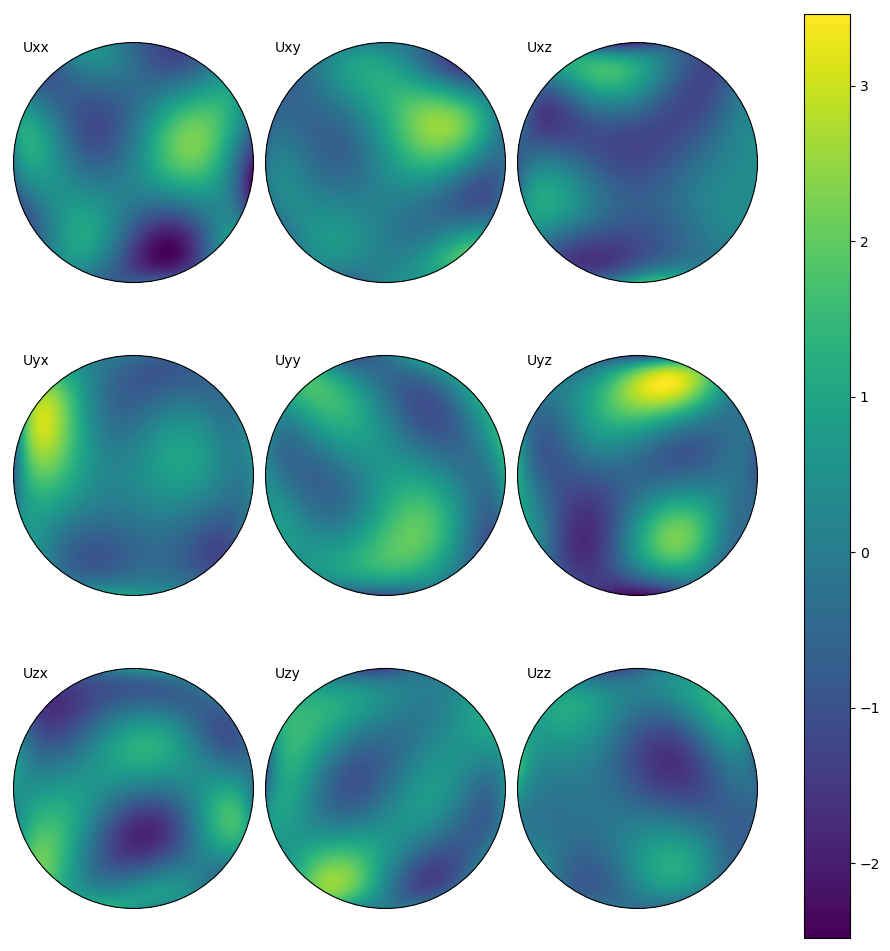

CPU times: user 17.2 s, sys: 689 ms, total: 17.9 s
Wall time: 9.81 s


In [18]:
%%time
rf = random_field(3, 3)
b = np.broadcast(*c2xyz(np.ix_(*mesh.grid())))
data = np.array([tensor_xyz2c(rf(*xyz), xyz) for xyz in b])
data = np.moveaxis(data, 0, -1).reshape(3, 3, *mesh.shape)
u = TensorField(mesh, data)
plot(u, x=1)

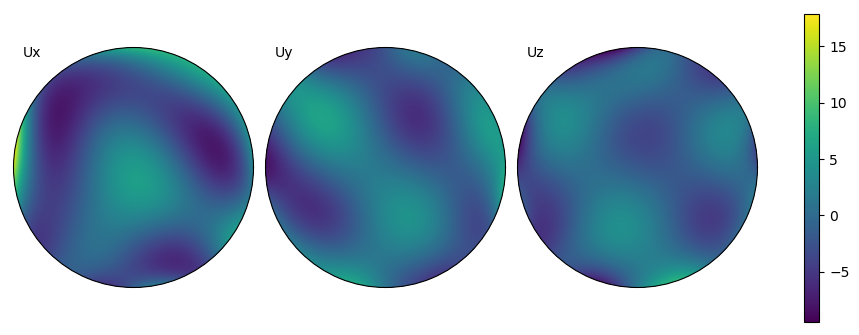

In [19]:
div_u = u.div(coord='cylindrical')
plot(div_u, x=1)

In [20]:
p = random_point()
xyz = c2xyz(p)
v = div_u(*p)

eps = 1e-5
d = [tensor_c2xyz(u(*xyz2c(xyz + delta)), xyz2c(xyz + delta)) - 
     tensor_c2xyz(u(*xyz2c(xyz - delta)), xyz2c(xyz - delta))
     for delta in eps*np.eye(3)]
v1_xyz = np.trace(d)/2/eps
v1 = vector_xyz2c(v1_xyz, xyz)
diff(v, v1)

1.6904335865536176e-10

## Integration

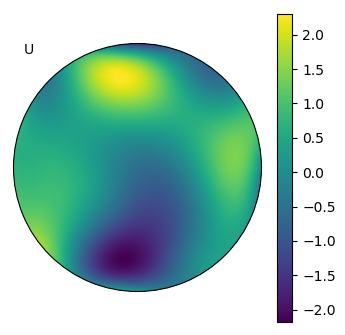

In [21]:
x, y, z = c2xyz(np.ix_(*mesh.grid()))
rf = random_field()                       
u = TensorField(mesh, np.vectorize(rf)(x, y, z))
plot(u, x=1)

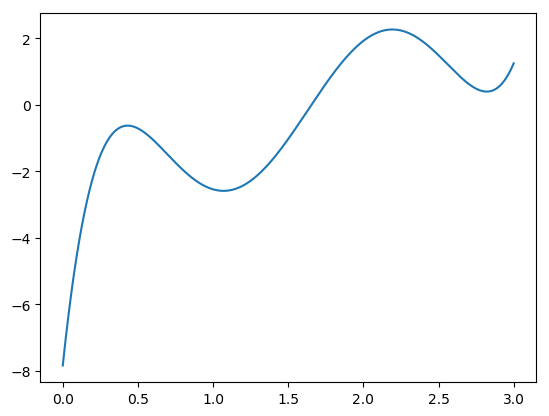

In [22]:
x = np.linspace(0, L, 3000)
u_int = u.int(1, 2, coord='cylindrical')
plt.plot(x, u_int(x))

In [23]:
u.int(coord='cylindrical')

-1.420972177813322

In [24]:
np.trapz(u_int(x), x)

-1.420974866611037

In [25]:
u_int.int()

array(-1.42097218)

In [26]:
x = np.linspace(*mesh_x.endpoints, 300)
r = np.linspace(*mesh_r.endpoints, 300)
phi = np.linspace(*mesh_phi.endpoints, 300)

int_x = np.trapz(u(x, r, phi)*r[:,None], x, axis=0)
int_xr = np.trapz(int_x, r, axis=0)
int_xrphi = np.trapz(int_xr, phi, axis=0)
diff(u.int(coord='cylindrical'), int_xrphi)

0.0002279620370821424